# Part 1: Cleaning and tokenizing the data. df_big refers to the whole 995K FakeNewsCorpus dataset and df refers to the sample. 


In [1]:
#importing packages
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from cleantext import clean
import nltk
from nltk.corpus import stopwords
from functools import reduce
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliagrundemar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1

In [2]:
df= pd.read_csv('news_sample.csv', index_col=0)

In [3]:
#Cleaning data using the cleantext library
def cleantext_clean(data):
    #As clean did not have arguments for date we wrote our own using regular expressions 
    date_formats = [
        r'\d{2,4}/\d{1,2}/\d{2,4}(.*)',   # e.g 12/31/2021 or 12/31/21
        r'\d{2,4}-\d{1,2}-\d{2,4}(.*)',   # e.g 12-31-2021 or 12-31-21
        ]

    for date_format in date_formats:
        data = re.sub(date_format, '<DATE>', str(data))

    data = clean(data, lower=True, normalize_whitespace=True, no_urls=True, no_emails = True, no_numbers= True,
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_number="<NUM>",)
    return data
    
for column in df.columns:
    df[column] = df[column].apply(cleantext_clean)



In [4]:
#Calculating the size of the vocabulary before processing
def word_list(data): 
    word_list = []
    for column in data.columns: 
        words = data[column].tolist()
        words = [word for segments in words for word in str(segments).split()]
        word_list = word_list + words
    return word_list
vc_size_before_processing = len(set(word_list(df)))

In [5]:
#Removing stopwords and stemming
def remove_stopwords(data):
    stop_words = set(stopwords.words('english'))
    words = str(data).split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def stem_input(data):
    ps = PorterStemmer()
    words = str(data).split()
    return reduce(lambda x, y: x + ' ' + ps.stem(y), words, '')

for column in df.columns:
    df[column] = df[column].apply(remove_stopwords)


In [6]:
#Calculating the size of the vocabulary after removing stopwords and stemming
vc_size_no_stopwords = len(set(word_list(df)))
print(vc_size_before_processing)
print(vc_size_no_stopwords)

reduction_rate_stopwords = ((vc_size_before_processing-vc_size_no_stopwords)/ vc_size_before_processing) * 100
print(reduction_rate_stopwords, '%')

for column in df.columns:
    df[column] = df[column].apply(stem_input)

vc_size_stemming = len(set(word_list(df)))
reduction_rate_stemming = ((vc_size_before_processing-vc_size_stemming) / vc_size_before_processing) * 100
print(reduction_rate_stemming, '%')
print(vc_size_stemming)

26773
26623
0.5602659395659806 %
17.659582415119708 %
22045


## Task 2, 3. df_big_cleaned refers to the cleaned big dataset, which we did locally and saved to a csv-file. 

In [9]:
df_big= pd.read_csv('995,000_rows.csv', index_col=0)
df_big_cleaned = pd.read_csv('cleaned_dataset.csv') 

In [10]:
#Counting how many NaN-values are in the author column
nan_count = df_big['authors'].isna().sum()

(nan_count/ len(df_big['authors'])) * 100

df1 = df_big.copy()
df1['type'] = df1['type'].replace(['bias','conspiracy','fake','hate','junksci','satire'],'fake')
df1['type'] = df1['type'].replace(['political','reliable','clickbait'],'reliable')

df_fake = df1[df1['type'] == 'fake']
df_reliable = df1[df1['type'] == 'reliable']

print ("fake author nan %: ", ((df_fake['authors'].isna().sum()/ len(df_fake['authors']) * 100)))
print ("reliable author nan %: ", ((df_reliable['authors'].isna().sum()/ len(df_reliable['authors']) * 100)))

Fake author nan %:  56.770833333333336
reliable author nan %:  38.333333333333336


In [11]:
#Creates a pandas Series of the frequency of every word in the data to calculate how often each word appears
def word_frequency(data_frame):
    word_freq = {}
    for column in data_frame.columns:
        text = data_frame[column]
        all_text = ' '.join(str(item) for item in text)
        words = all_text.split()
        for word in words:
            if (word != "<num>") and (word != "<num>,") and (word != "<num>.") and (word != "<num>:") and (word != "<url>") and (word != "<email>") and (word != "nan") and (word != "<date>") and (word != ",")and (word != ".") and (word != "-") and (word != "/") and (word != "['']"):
                word_freq[word] = word_freq.get(word, 0) + 1
    
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_word_freq

frequencies_before = word_frequency(df_big)
len(frequencies_before)

75108

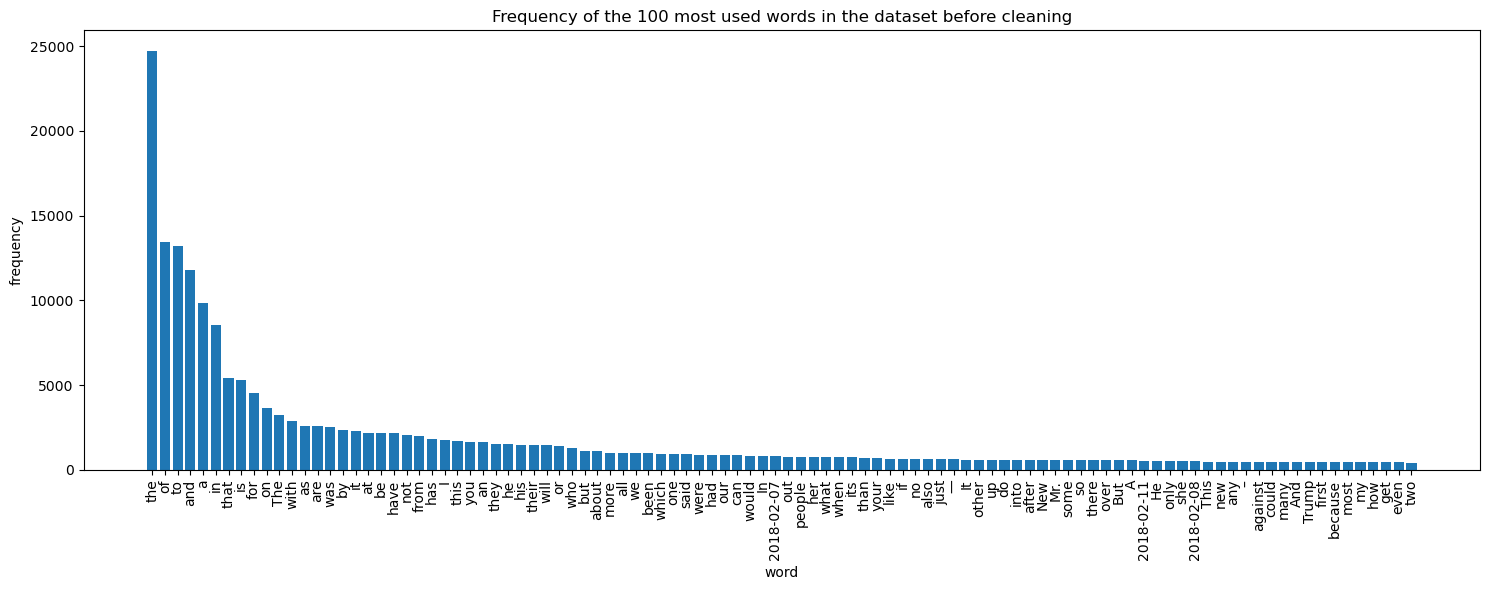

In [12]:
#100 most frequent words before cleaning
hundred_most_frequent_before = frequencies_before[:100]

words, freqs = zip(*hundred_most_frequent_before)

plt.figure(figsize=(15, 6))
plt.bar(words, freqs)
plt.xlabel('word')
plt.ylabel('frequency')
plt.title('Frequency of the 100 most used words in the dataset before cleaning')
plt.xticks(rotation=90)
plt.tight_layout() 
plt.show()

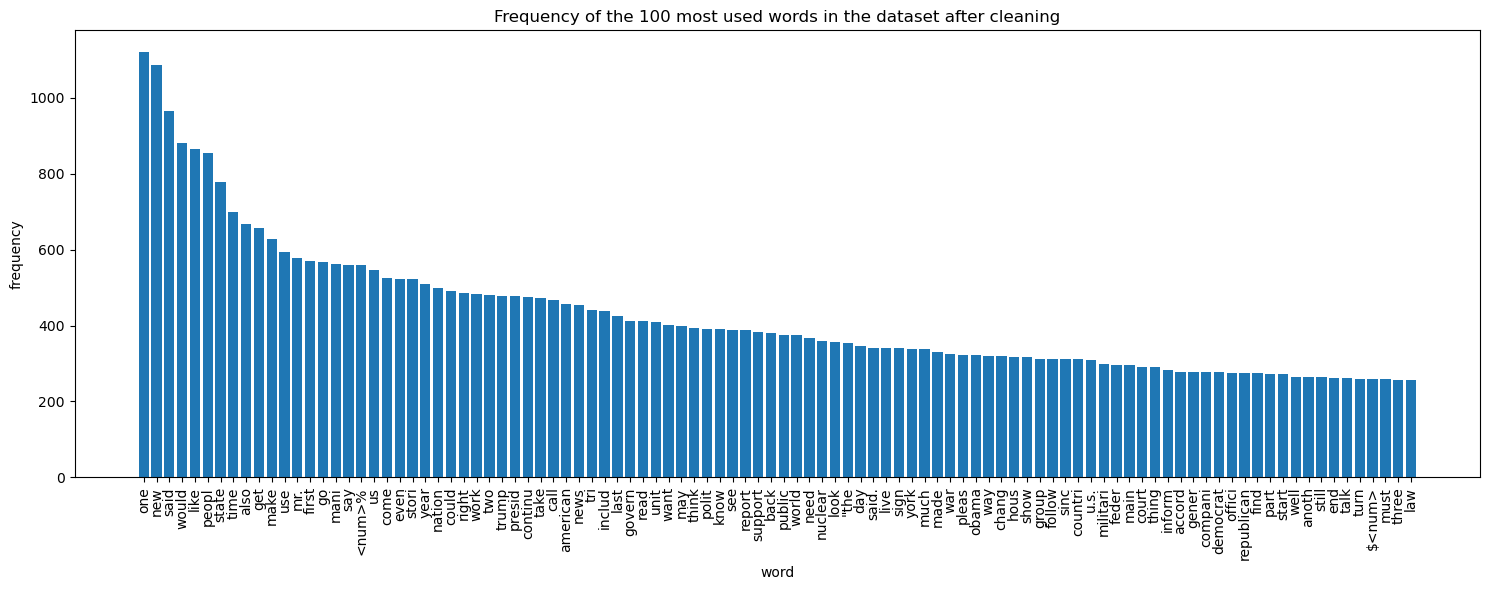

In [13]:
#100 most frequent words after cleaning 
frequencies_after = word_frequency(df_big_cleaned)
hundred_most_frequent_after = frequencies_after[:100]

words, freqs = zip(*hundred_most_frequent_after)
plt.figure(figsize=(15, 6))
plt.bar(words, freqs)
plt.xlabel('word')
plt.ylabel('frequency')
plt.title('Frequency of the 100 most used words in the dataset after cleaning')
plt.xticks(rotation=90)
plt.tight_layout() 
plt.show()

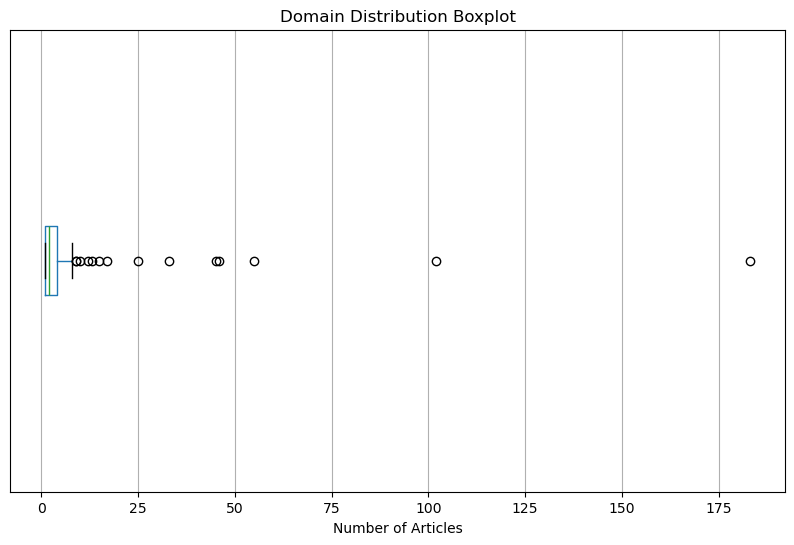

,Count
count,199.000000
mean,5.025126
std,15.967593
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,183.000000


In [14]:
#Grouping articles by domain and counting the number of articles for each domain
domain_counts = df_big['domain'].value_counts()
domain_counts_df = pd.DataFrame(domain_counts.reset_index())
domain_counts_df.columns = ['Domain', 'Count']

#Creating a boxplot
plt.figure(figsize=(10, 6))
domain_counts_df.boxplot(column='Count', vert=False)
plt.title('Domain Distribution Boxplot')
plt.xlabel('Number of Articles')
plt.yticks([])
plt.grid(True)
plt.show()

domain_counts_df.describe()

In [15]:
#Counting the number of unique domains in the dataset
unique_domain = df['domain'].unique()
results = []
for domain in unique_domain:
  domain_df = df[df['domain'] == domain]
  total = len(domain_df)
  fake = len(domain_df[domain_df['type'] == 'fake'])
  reliable = total - fake
  fake_of_total = fake / total
  results.append((domain, total, fake, reliable, fake_of_total))

results_df = pd.DataFrame(results, columns=['Domain', 'total', 'Fake Articles', 'Reliable Articles', 'Proportion Fake to Total'])

results_df

,Domain,total,Fake Articles,Reliable Articles,Proportion Fake to Total
0,awm.com,2,0,2,0.0
1,beforeitsnews.com,155,0,155,0.0
2,cnnnext.com,1,0,1,0.0
3,bipartisanreport.com,1,0,1,0.0
4,blackagendareport.com,1,0,1,0.0
5,awarenessact.com,6,0,6,0.0
6,canadafreepress.com,24,0,24,0.0
7,christianpost.com,3,0,3,0.0
8,charismanews.com,1,0,1,0.0
9,barenakedislam.com,1,0,1,0.0


In [16]:
#Calculate the distribution of domains 
domain_distribution = df_big_cleaned['domain'].value_counts()
percentage_distribution = domain_distribution / domain_distribution.sum() * 100
print(percentage_distribution)

type_distribution = df_big_cleaned['type'].value_counts()
percentage_distribution = type_distribution / type_distribution.sum() * 100
print(percentage_distribution)

domain
nytimes.com               18.3
beforeitsnews.com         10.2
dailykos.com               5.5
nationalreview.com         4.6
express.co.uk              4.5
                          ... 
beehivebugle.com           0.1
projectveritas.com         0.1
commentarymagazine.com     0.1
ifyouonlynews.com          0.1
mintpressnews.com          0.1
Name: count, Length: 199, dtype: float64
type
reliable      23.133544
political     17.560463
fake          12.723449
bias          11.566772
conspiracy    10.830705
unreliable     5.573081
unknown        5.047319
rumor          4.837014
clickbait      3.470032
satire         2.313354
hate           1.577287
junksci        1.366982
Name: count, dtype: float64


## Task 4

In [17]:
#Splitting data into training, validation and test data
x=df_big_cleaned.drop(columns=['type'])
y=df_big_cleaned['type']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5,random_state=42)